# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [1]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [2]:
import decoupler as dc

In [3]:
dc.__version__

'1.5.0'

In [4]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [5]:
adata = sc.read_h5ad(input_path) 

In [6]:
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [7]:
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

In [8]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma                      704834
normal                                   212889
squamous cell lung carcinoma             190199
non-small cell lung carcinoma            120796
chronic obstructive pulmonary disease     55254
Name: count, dtype: int64

In [9]:
adata.obs.tumor_stage.value_counts()

tumor_stage
early         725412
advanced      288981
non-cancer    268143
Name: count, dtype: int64

In [10]:
adata.obs.sex.value_counts()

sex
male       676587
female     571042
unknown     36343
Name: count, dtype: int64

In [11]:
adata.obs.origin.value_counts()

origin
tumor_primary       585138
normal_adjacent     345211
normal              281363
tumor_metastasis     71272
nan                    988
Name: count, dtype: int64

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [12]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [13]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [14]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma              577317
squamous cell lung carcinoma     189044
non-small cell lung carcinoma    120796
Name: count, dtype: int64

In [15]:
adata.obs.tumor_stage.value_counts()

tumor_stage
early       672760
advanced    214397
Name: count, dtype: int64

In [16]:
adata.obs.sex.value_counts()

sex
male      500302
female    386855
Name: count, dtype: int64

In [17]:
adata.obs.origin.value_counts()

origin
tumor_primary      571045
normal_adjacent    316112
Name: count, dtype: int64

### 02.CELL TPYE RE-CLASIFICATION 

In [18]:
adata.obs.cell_type.value_counts()

cell_type
CD4-positive, alpha-beta T cell         152247
CD8-positive, alpha-beta T cell         123252
alveolar macrophage                      82844
macrophage                               78660
malignant cell                           75457
natural killer cell                      50680
B cell                                   44609
classical monocyte                       43364
regulatory T cell                        33603
plasma cell                              31876
epithelial cell of lung                  23013
CD1c-positive myeloid dendritic cell     20734
neutrophil                               18706
type II pneumocyte                       16274
vein endothelial cell                    15849
mast cell                                14361
capillary endothelial cell               10870
multi-ciliated epithelial cell            6413
non-classical monocyte                    6103
myeloid cell                              5544
fibroblast of lung                        5091
bro

In [19]:
adata.obs.cell_type_major.value_counts()

cell_type_major
T cell CD4               149343
T cell CD8               120586
Macrophage alveolar       82844
Macrophage                78660
Tumor cells               75457
NK cell                   50094
Monocyte                  49467
B cell                    44307
T cell regulatory         33603
Endothelial cell          32443
Plasma cell               30292
transitional club/AT2     22894
cDC2                      20734
Neutrophils               18706
Alveolar cell type 2      16274
Mast cell                 14361
other                     14017
Stromal                   13948
Ciliated                   6413
pDC                        3800
Alveolar cell type 1       3739
cDC1                       2097
Club                       1580
DC mature                  1498
Name: count, dtype: int64

In [20]:
cells_of_interest=['alveolar macrophage', 'neutrophil',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [21]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'alveolar macrophage',
 'epithelial cell of lung',
 'macrophage',
 'malignant cell',
 'multi-ciliated epithelial cell',
 'neutrophil',
 'regulatory T cell'}

In [22]:
set(subset_adata.obs.cell_type_major)

{'B cell',
 'Ciliated',
 'Macrophage',
 'Macrophage alveolar',
 'Neutrophils',
 'T cell CD4',
 'T cell CD8',
 'T cell regulatory',
 'Tumor cells',
 'other',
 'transitional club/AT2'}

In [23]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

/tmp/ipykernel_64382/2170802957.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
/tmp/ipykernel_64382/2170802957.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
/tmp/ipykernel_64382/2170802957.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, 

In [24]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4+ T cell',
 'CD8+ T cell',
 'epithelial cell',
 'macrophage',
 'malignant cell',
 'neutrophil',
 'regulatory T cell'}

In [25]:
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [26]:
subset_adata.obs.disease.value_counts()

disease
lung adenocarcinoma              409606
squamous cell lung carcinoma     134606
non-small cell lung carcinoma     94592
Name: count, dtype: int64

In [27]:
adata

View of AnnData object with n_obs × n_vars = 887157 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

## PAIRED SAMPLES REMOVE NSCLC 

In [28]:
subset_adata = subset_adata[(subset_adata.obs["disease"]!="non-small cell lung carcinoma")]

In [29]:
#subset_adata = subset_adata[(subset_adata.obs["disease"]!="squamous cell lung carcinoma")]

In [30]:
df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()

/tmp/ipykernel_64382/1850072068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()


In [31]:
df_grouped.reset_index(inplace= True)

In [32]:
df_grouped_normal = df_grouped[df_grouped["origin"]=="normal_adjacent"]

In [33]:
df_grouped_normal = df_grouped_normal[df_grouped_normal['sample'] != 0]

In [34]:
df_grouped_tumor = df_grouped[df_grouped["origin"]=="tumor_primary"]

In [35]:
df_grouped_tumor = df_grouped_tumor[df_grouped_tumor['sample'] != 0]

In [36]:
list(set(df_grouped_tumor.donor_id))

['Wu_Zhou_2021_P22',
 'Lambrechts_Thienpont_2018_6149v1_1',
 'Wu_Zhou_2021_P35',
 'Guo_Zhang_2018_P1010',
 'Leader_Merad_2021_630',
 'Wu_Zhou_2021_P38',
 'Wu_Zhou_2021_P21',
 'Leader_Merad_2021_706',
 'Lambrechts_Thienpont_2018_6149v2_4',
 'UKIM-V-2_P14',
 'Kim_Lee_2020_P0019',
 'Wu_Zhou_2021_P3',
 'Maynard_Bivona_2020_TH236',
 'Leader_Merad_2021_410',
 'Wu_Zhou_2021_P41',
 'Leader_Merad_2021_522',
 'Kim_Lee_2020_P0009',
 'Leader_Merad_2021_695',
 'Wu_Zhou_2021_P5',
 'Leader_Merad_2021_514',
 'Maynard_Bivona_2020_TH179',
 'UKIM-V_P1',
 'Guo_Zhang_2018_P1219',
 'Wu_Zhou_2021_P32',
 'Zilionis_Klein_2019_patient_4',
 'Leader_Merad_2021_572',
 'Leader_Merad_2021_800',
 'Wu_Zhou_2021_P16',
 'Wu_Zhou_2021_P30',
 'UKIM-V-2_P12',
 'Maynard_Bivona_2020_TH158',
 'Wu_Zhou_2021_P17',
 'Wu_Zhou_2021_P15',
 'Goveia_Carmeliet_2020_patient_32',
 'Wu_Zhou_2021_P6',
 'Wu_Zhou_2021_P14',
 'Zilionis_Klein_2019_patient_6',
 'Leader_Merad_2021_729',
 'Leader_Merad_2021_532',
 'Kim_Lee_2020_P0025',
 'Wu_Zhou

In [37]:
common_ids =list(set(df_grouped_normal.donor_id)& set(df_grouped_tumor.donor_id))

In [38]:
len(common_ids)

82

In [39]:
paired_adata = subset_adata[subset_adata.obs['donor_id'].isin(common_ids)].copy()

In [40]:
df = paired_adata.obs#
origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()
origin_counts.columns = ['origin', 'count']

/tmp/ipykernel_64382/2715583478.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()


/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


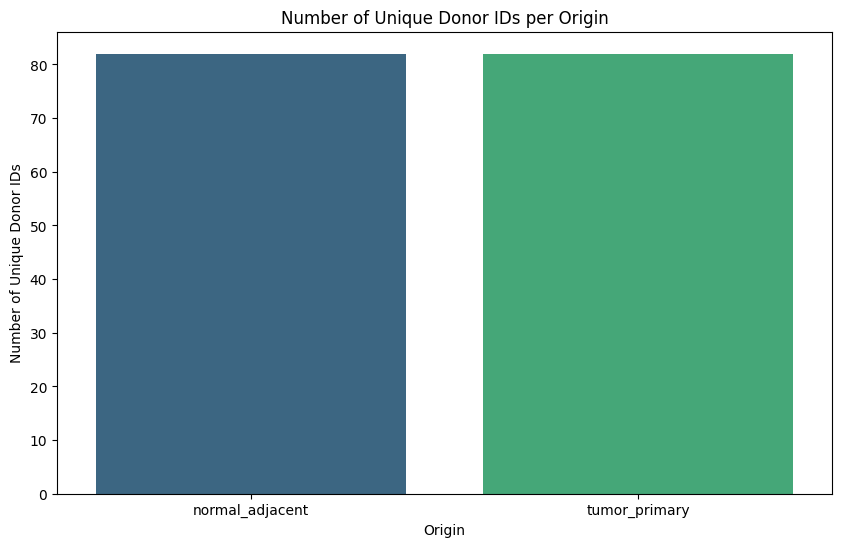

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')
plt.xlabel('Origin')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per Origin')
plt.show()

In [42]:
df = paired_adata.obs#
origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()
origin_counts.columns = ['disease', 'count']

/tmp/ipykernel_64382/3679065484.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()


/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


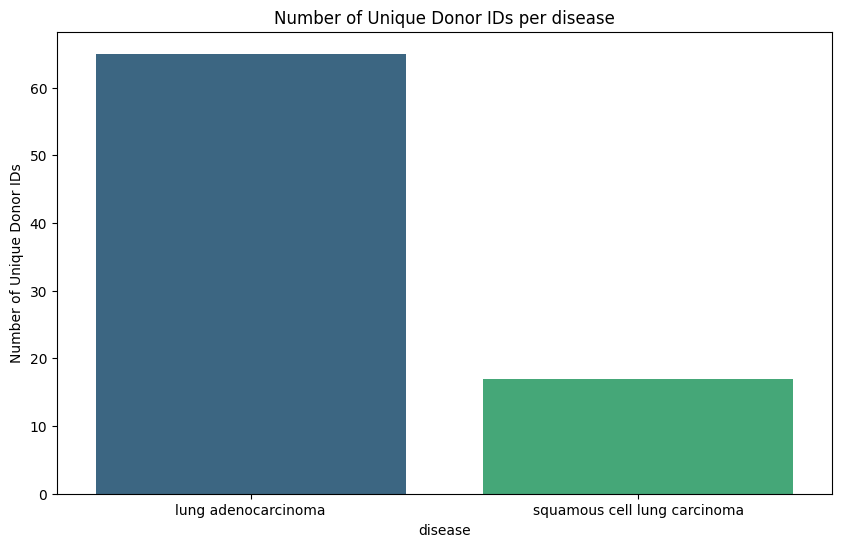

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')
plt.xlabel('disease')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per disease')
plt.show()

## SUMMARY 
- Filtered for male, female & tumor, normal_adjacent
- Filtered and reclassified cells of interest: 'B cell','CD4+ T cell', 'CD8+ T cell', 'epithelial cell', 'macrophage', 'malignant cell', 'neutrophil', 'regulatory Tcell'
- Filtered to exclude samples coming from NSCLC
- Filtered for PAIRED SAMPLES (82 donor_id that have normal_adjacent and tumor_primary  samples)
- KEEP LUADN AND LUSC

### 04.Compute pseudobulk

In [44]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    paired_adata,
    sample_col='sample',
    groups_col='donor_id',
    layer='count',
    min_cells=0,
    min_counts=0
)

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/home/kvalem/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [45]:
#pdata_var_concat =pd.concat([pdata.var, nsclc_chrom],axis=1)

In [46]:
#pdata_var_concat

In [47]:
pdata.obs["age"] = pdata.obs["age"].astype("float64")
pdata.obs["is_primary_data"] = pdata.obs["is_primary_data"].astype(bool)


In [48]:
pdata.write_h5ad(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/pdata.h5ad")

In [49]:
#pdata = sc.read_h5ad(f"{path}/out/008_analysis_paired_luad/tables/input/pdata.h5ad")

In [50]:
pdata

AnnData object with n_obs × n_vars = 239 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

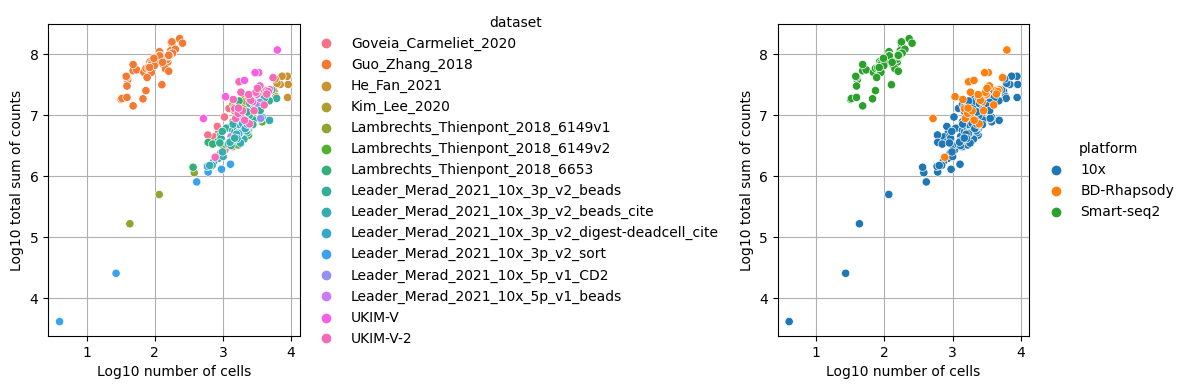

In [51]:
dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform'], figsize=(12, 4))

In [52]:
#pdata = pdata[pdata.obs["dataset"]!="Guo_Zhang_2018"] ## SMART SEQ 

In [53]:
#pdata

In [54]:
#dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform'], figsize=(12, 4))

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


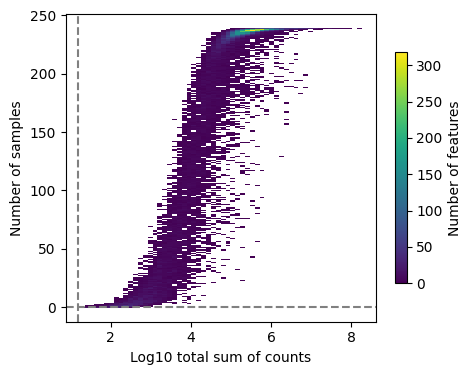

In [55]:
dc.plot_filter_by_expr(pdata, group='sample', min_count=10, min_total_count=15)

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


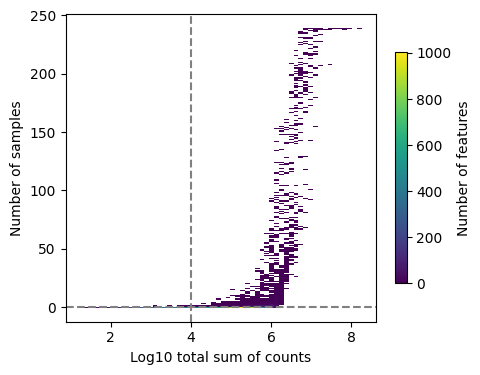

In [56]:
dc.plot_filter_by_expr(pdata, group='sample', large_n=100,min_prop=0.9, min_count=5000, min_total_count=10000)

I set this threshold for the DS analysis to avoid havinh zero-inflated data

In [57]:
# Obtain genes that pass the thresholds 
genes = dc.filter_by_expr(pdata, group='sample', min_count=5000, min_total_count=10000)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 239 × 1776
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [58]:
pdata.layers["counts"] = pdata.X

In [59]:
scales_counts = sc.pp.normalize_total(pdata, target_sum=None, inplace=False)
# log1p transform
pdata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [60]:
pdata

AnnData object with n_obs × n_vars = 239 × 1776
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props', 'counts', 'log1p_norm'

In [61]:
### Samplesheet
samplesheet = pdata.obs.copy()
samplesheet["sample"]=samplesheet.index
samplesheet.reset_index(inplace=True)

In [62]:
samplesheet.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/samplesheet.csv", index=False)
samplesheet.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/samplesheet.tsv", index=False, sep = "\t")

In [63]:
bulk_df = pdata.to_df().T

In [64]:
### Raw counts
bulk_df = pdata.to_df().T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")

In [65]:
bulk_df.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/counts.csv")    

In [66]:
### log1p_norm counts
pdata_log1p_norm = pd.DataFrame(pdata.layers["log1p_norm"], 
    pdata.to_df().index, 
    pdata.to_df().columns)
bulk_df = pdata_log1p_norm.T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
bulk_df.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/log1p_norm_counts.csv")    

### 0.4 Create counts and samplesheet independent for tumor and normal for DESEQ2 

In [67]:
pdata_normal = pdata[pdata.obs["origin"]=="normal_adjacent"]
pdata_tumor = pdata[pdata.obs["origin"]=="tumor_primary"]

In [68]:
pdata_normal

View of AnnData object with n_obs × n_vars = 109 × 1776
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props', 'counts', 'log1p_norm'

In [69]:
pdata_list = [pdata_normal,pdata_tumor]
pdata_list_name = ["normal","tumor"]

for index, dataframe in enumerate(pdata_list):
    print(pdata_list_name[index])
    # Perform the operations
    samplesheet = dataframe.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/samplesheet_{pdata_list_name[index]}.csv", index=False)
    samplesheet.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/samplesheet_{pdata_list_name[index]}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = dataframe.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/counts_{pdata_list_name[index]}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(dataframe.layers["log1p_norm"], 
        dataframe.to_df().index, 
        dataframe.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/out/011_analysis_paired_luad_lusc_include_guon/tables/input/log1p_norm_counts_{pdata_list_name[index]}.csv")    

normal
tumor


## SUMMARY 
- Filtered for male, female & tumor, normal_adjacent
- Filtered and reclassified cells of interest: 'B cell','CD4+ T cell', 'CD8+ T cell', 'epithelial cell', 'macrophage', 'malignant cell', 'neutrophil', 'regulatory Tcell'
- Filtered to exclude samples coming from NSCLC
- Filtered for PAIRED SAMPLES (82 donor_id that have normal_adjacent and tumor_primary  samples)
 